In [7]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
%matplotlib inline
warnings.filterwarnings("ignore")

### Load and preprocess the data

In [8]:
df = pd.read_csv("cleaned_data.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

In [9]:
df.head()

,INF_A,INF_B
DATE,,
1996-12-29,0.0,0.0
1997-02-23,0.0,0.0
1997-03-02,0.0,0.0
1997-03-09,0.0,0.0
1997-03-16,0.0,0.0


#### Scaling the data using MinMaxScaler
#### Taking data upto 2023 for training and remaining for testing
#### Buliding the Transformer model
#### Optimizer: Adam, loss: mse, epochs:50, batch size:32


Processing INF_A...
1/1 [==============================] - 0s 15ms/step
INF_A - RMSE: 23.12, MAE: 19.73, MAPE: 78.37%


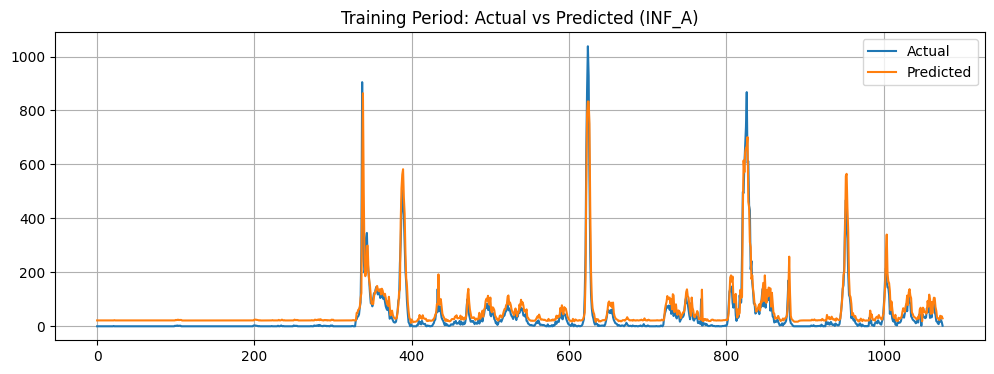

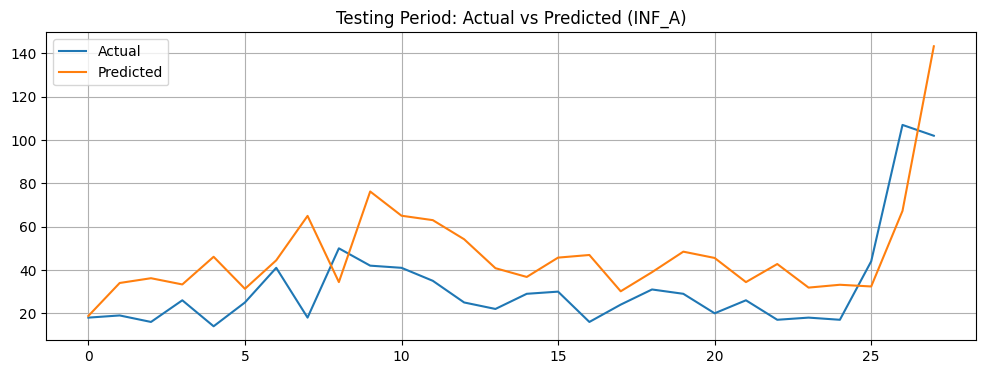


Processing INF_B...
1/1 [==============================] - 0s 14ms/step
INF_B - RMSE: 5.58, MAE: 4.10, MAPE: 94.32%


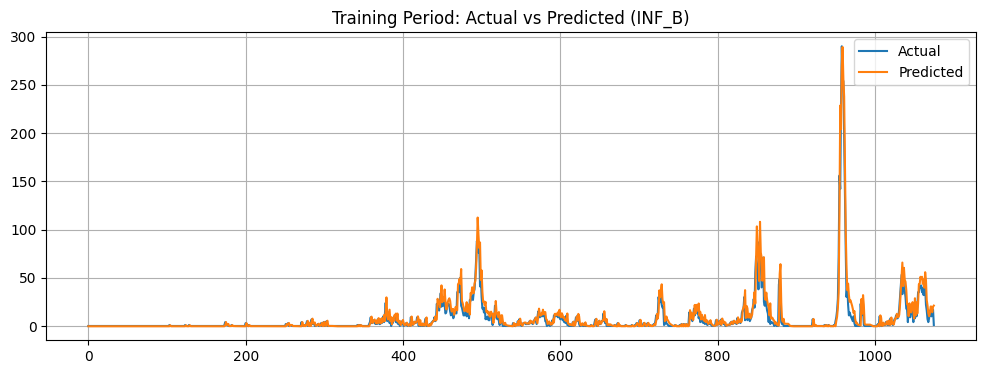

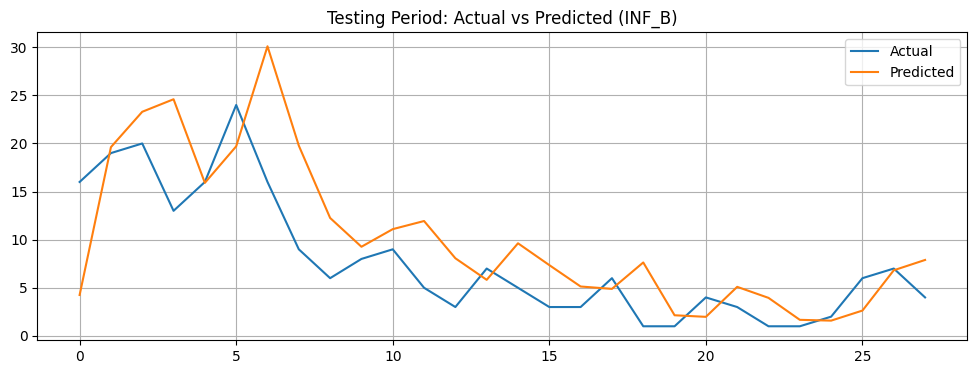

In [10]:
for col in ['INF_A', 'INF_B']:
    print(f"\nProcessing {col}...")

    # Prepare data
    data = df[[col]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_len=12):
        xs, ys = [], []
        for i in range(len(data) - seq_len):
            xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len])
        return np.array(xs), np.array(ys)

    SEQ_LEN = 12
    X, y = create_sequences(data_scaled, SEQ_LEN)

    # Train-test split
    split_date = '2024'
    split_idx = df.index < split_date
    X_train = X[split_idx[SEQ_LEN:]]
    y_train = y[split_idx[SEQ_LEN:]]
    X_test = X[~split_idx[SEQ_LEN:]]
    y_test = y[~split_idx[SEQ_LEN:]]

    # Build Transformer model
    class TimeSeriesTransformer(tf.keras.Model):
        def __init__(self, seq_len, d_model=64, num_heads=4):
            super().__init__()
            self.embedding = tf.keras.layers.Dense(d_model)
            self.pos_encoding = self.add_weight(
                "pos_encoding",
                shape=(1, seq_len, d_model),
                initializer="random_normal",
                trainable=True
            )
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
            self.norm1 = tf.keras.layers.LayerNormalization()
            self.norm2 = tf.keras.layers.LayerNormalization()
            self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(d_model * 2, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ])
            self.output_layer = tf.keras.layers.Dense(1)

        def call(self, x):
            x = self.embedding(x)
            x += self.pos_encoding
            attn_output = self.attention(x, x)
            x = self.norm1(x + attn_output)
            ffn_output = self.ffn(x)
            x = self.norm2(x + ffn_output)
            return self.output_layer(x[:, -1, :])

    model = TimeSeriesTransformer(seq_len=SEQ_LEN)
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate on train
    train_preds = model.predict(X_train)
    train_preds_inv = scaler.inverse_transform(train_preds)
    y_train_inv = scaler.inverse_transform(y_train)

    # Evaluate on test
    test_preds = model.predict(X_test)
    test_preds_inv = scaler.inverse_transform(test_preds)
    y_test_inv = scaler.inverse_transform(y_test)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))
    mae = mean_absolute_error(y_test_inv, test_preds_inv)
    mape = np.mean(np.abs((y_test_inv - test_preds_inv) / y_test_inv)) * 100

    print(f"{col} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    # Plot training
    plt.figure(figsize=(12, 4))
    plt.plot(y_train_inv, label='Actual')
    plt.plot(train_preds_inv, label='Predicted')
    plt.title(f'Training Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot testing
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(test_preds_inv, label='Predicted')
    plt.title(f'Testing Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

### Hyper Parameter Tunning


Hyperparameter tuning for INF_A...
1/1 [==============================] - 0s 234ms/step
Best Hyperparameters for INF_A: {'d_model': 32, 'num_heads': 2, 'batch_size': 16, 'epochs': 30}
Metrics (RMSE, MAE, MAPE): 17.72, 14.01, 54.92%
1/1 [==============================] - 0s 27ms/step


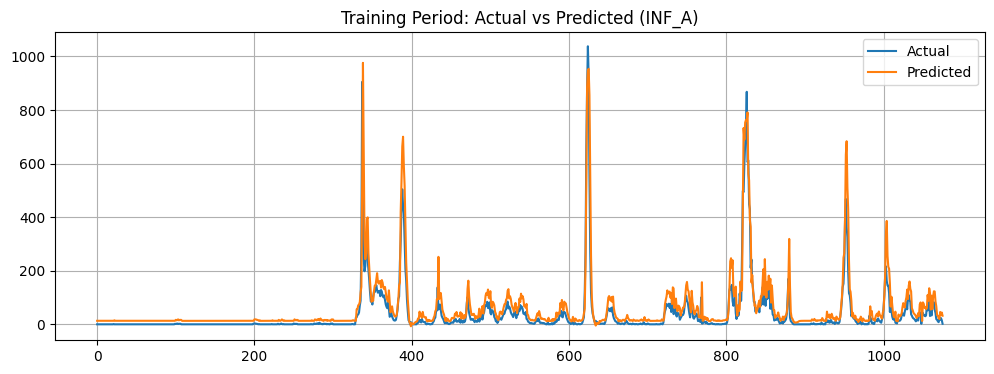

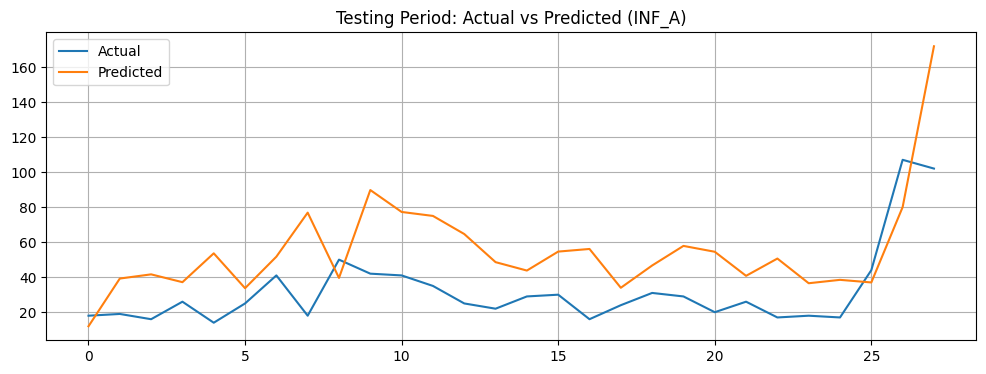


Hyperparameter tuning for INF_B...
1/1 [==============================] - 0s 121ms/step
Best Hyperparameters for INF_B: {'d_model': 32, 'num_heads': 2, 'batch_size': 16, 'epochs': 50}
Metrics (RMSE, MAE, MAPE): 4.35, 3.29, 67.04%
1/1 [==============================] - 0s 15ms/step


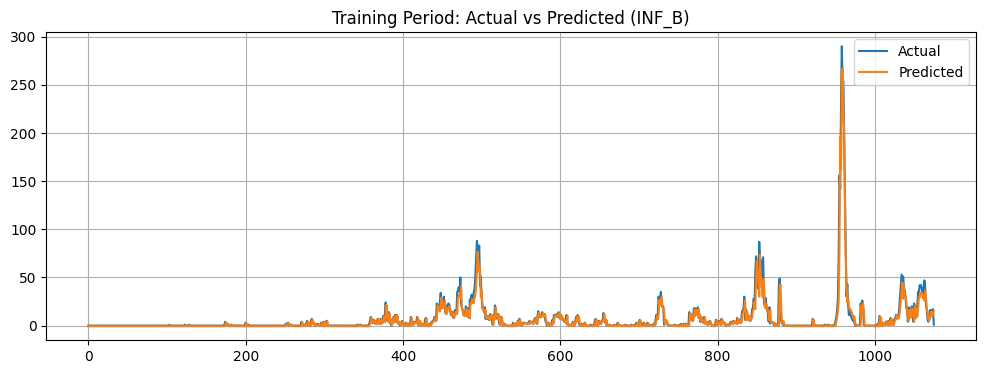

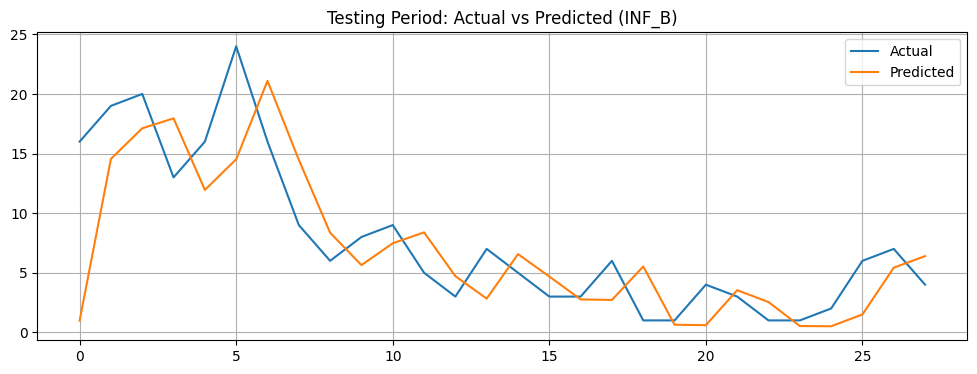

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from itertools import product

# Load and preprocess the data
df = pd.read_csv("cleaned_data.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

for col in ['INF_A', 'INF_B']:
    print(f"\nHyperparameter tuning for {col}...")

    # Prepare data
    data = df[[col]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_len=12):
        xs, ys = [], []
        for i in range(len(data) - seq_len):
            xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len])
        return np.array(xs), np.array(ys)

    SEQ_LEN = 12
    X, y = create_sequences(data_scaled, SEQ_LEN)

    # Train-test split
    split_date = '2024'
    split_idx = df.index < split_date
    X_train = X[split_idx[SEQ_LEN:]]
    y_train = y[split_idx[SEQ_LEN:]]
    X_test = X[~split_idx[SEQ_LEN:]]
    y_test = y[~split_idx[SEQ_LEN:]]

    # Define model class
    class TimeSeriesTransformer(tf.keras.Model):
        def __init__(self, seq_len, d_model=64, num_heads=4):
            super().__init__()
            self.embedding = tf.keras.layers.Dense(d_model)
            self.pos_encoding = self.add_weight(
                "pos_encoding",
                shape=(1, seq_len, d_model),
                initializer="random_normal",
                trainable=True
            )
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
            self.norm1 = tf.keras.layers.LayerNormalization()
            self.norm2 = tf.keras.layers.LayerNormalization()
            self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(d_model * 2, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ])
            self.output_layer = tf.keras.layers.Dense(1)

        def call(self, x):
            x = self.embedding(x)
            x += self.pos_encoding
            attn_output = self.attention(x, x)
            x = self.norm1(x + attn_output)
            ffn_output = self.ffn(x)
            x = self.norm2(x + ffn_output)
            return self.output_layer(x[:, -1, :])

    # Define hyperparameters to search
    param_grid = {
        'd_model': [32, 64],
        'num_heads': [2, 4],
        'batch_size': [16, 32],
        'epochs': [30, 50]
    }

    best_metrics = {"rmse": float('inf')}
    best_params = None

    for d_model, num_heads, batch_size, epochs in product(*param_grid.values()):
        tf.keras.backend.clear_session()
        model = TimeSeriesTransformer(seq_len=SEQ_LEN, d_model=d_model, num_heads=num_heads)
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        test_preds = model.predict(X_test)
        test_preds_inv = scaler.inverse_transform(test_preds)
        y_test_inv = scaler.inverse_transform(y_test)

        rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))
        mae = mean_absolute_error(y_test_inv, test_preds_inv)
        mape = np.mean(np.abs((y_test_inv - test_preds_inv) / y_test_inv)) * 100

        if rmse < best_metrics["rmse"]:
            best_metrics = {"rmse": rmse, "mae": mae, "mape": mape}
            best_params = {
                'd_model': d_model,
                'num_heads': num_heads,
                'batch_size': batch_size,
                'epochs': epochs
            }

    print(f"Best Hyperparameters for {col}: {best_params}")
    print(f"Metrics (RMSE, MAE, MAPE): {best_metrics['rmse']:.2f}, {best_metrics['mae']:.2f}, {best_metrics['mape']:.2f}%")

    # Retrain final model
    model = TimeSeriesTransformer(seq_len=SEQ_LEN, d_model=best_params['d_model'], num_heads=best_params['num_heads'])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

    # Final predictions
    train_preds = model.predict(X_train)
    train_preds_inv = scaler.inverse_transform(train_preds)
    y_train_inv = scaler.inverse_transform(y_train)

    test_preds = model.predict(X_test)
    test_preds_inv = scaler.inverse_transform(test_preds)
    y_test_inv = scaler.inverse_transform(y_test)

    # Plot training
    plt.figure(figsize=(12, 4))
    plt.plot(y_train_inv, label='Actual')
    plt.plot(train_preds_inv, label='Predicted')
    plt.title(f'Training Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot testing
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(test_preds_inv, label='Predicted')
    plt.title(f'Testing Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

## Ruuning model for best parameters


Processing INF_A...
1/1 [==============================] - 0s 14ms/step
INF_A - RMSE: 18.71, MAE: 13.57, MAPE: 44.81%


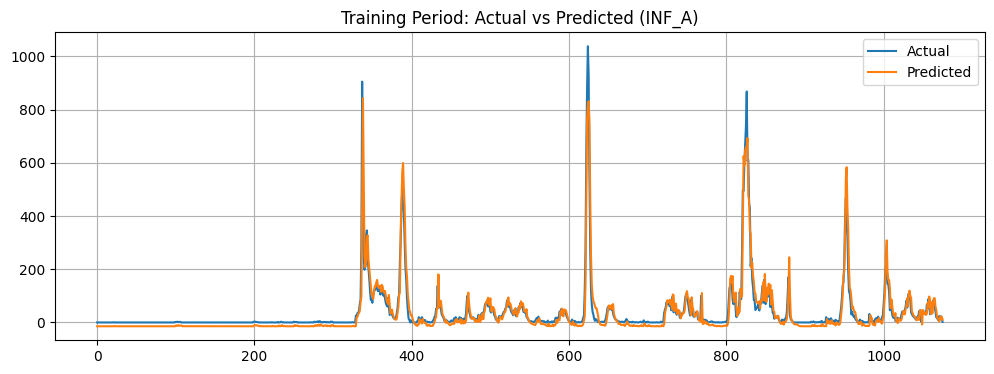

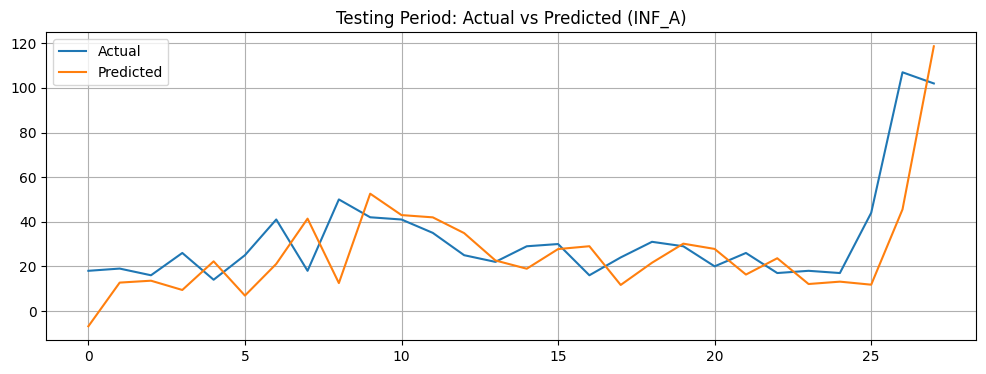


Processing INF_B...
1/1 [==============================] - 0s 12ms/step
INF_B - RMSE: 4.65, MAE: 3.59, MAPE: 69.61%


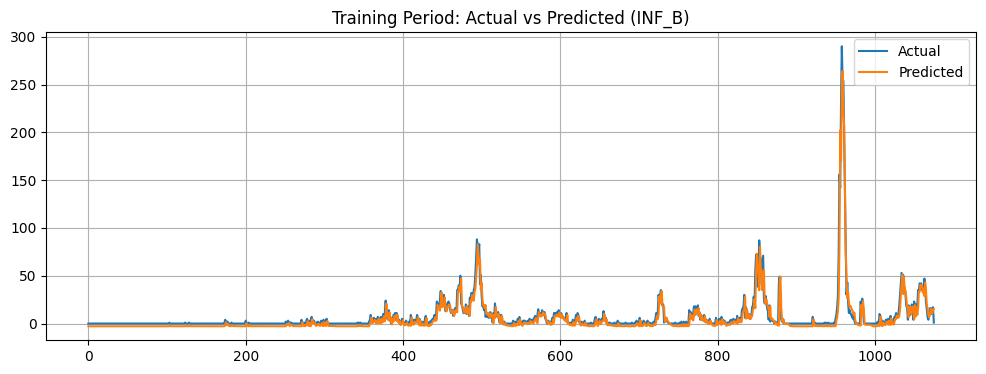

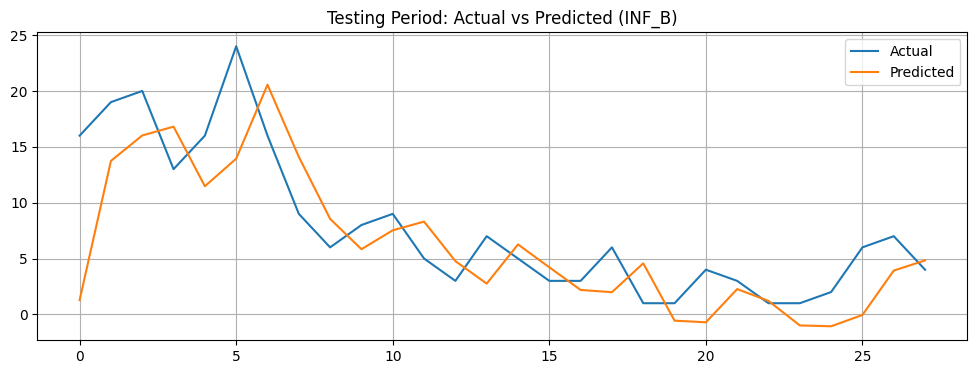

In [67]:
for col in ['INF_A', 'INF_B']:
    print(f"\nProcessing {col}...")

    # Prepare data
    data = df[[col]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_len=12):
        xs, ys = [], []
        for i in range(len(data) - seq_len):
            xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len])
        return np.array(xs), np.array(ys)

    SEQ_LEN = 12
    X, y = create_sequences(data_scaled, SEQ_LEN)

    # Train-test split
    split_date = '2024'
    split_idx = df.index < split_date
    X_train = X[split_idx[SEQ_LEN:]]
    y_train = y[split_idx[SEQ_LEN:]]
    X_test = X[~split_idx[SEQ_LEN:]]
    y_test = y[~split_idx[SEQ_LEN:]]

    # Build Transformer model
    class TimeSeriesTransformer(tf.keras.Model):
        def __init__(self, seq_len, d_model=32, num_heads=2):
            super().__init__()
            self.embedding = tf.keras.layers.Dense(d_model)
            self.pos_encoding = self.add_weight(
                "pos_encoding",
                shape=(1, seq_len, d_model),
                initializer="random_normal",
                trainable=True
            )
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
            self.norm1 = tf.keras.layers.LayerNormalization()
            self.norm2 = tf.keras.layers.LayerNormalization()
            self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(d_model * 2, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ])
            self.output_layer = tf.keras.layers.Dense(1)

        def call(self, x):
            x = self.embedding(x)
            x += self.pos_encoding
            attn_output = self.attention(x, x)
            x = self.norm1(x + attn_output)
            ffn_output = self.ffn(x)
            x = self.norm2(x + ffn_output)
            return self.output_layer(x[:, -1, :])

    model = TimeSeriesTransformer(seq_len=SEQ_LEN)
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

    # Evaluate on train
    train_preds = model.predict(X_train)
    train_preds_inv = scaler.inverse_transform(train_preds)
    y_train_inv = scaler.inverse_transform(y_train)

    # Evaluate on test
    test_preds = model.predict(X_test)
    test_preds_inv = scaler.inverse_transform(test_preds)
    y_test_inv = scaler.inverse_transform(y_test)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))
    mae = mean_absolute_error(y_test_inv, test_preds_inv)
    mape = np.mean(np.abs((y_test_inv - test_preds_inv) / y_test_inv)) * 100

    print(f"{col} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    # Plot training
    plt.figure(figsize=(12, 4))
    plt.plot(y_train_inv, label='Actual')
    plt.plot(train_preds_inv, label='Predicted')
    plt.title(f'Training Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot testing
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(test_preds_inv, label='Predicted')
    plt.title(f'Testing Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

### For INF_B, let us do some experiments

#### Trying different parameters


Processing INF_A...
1/1 [==============================] - 0s 9ms/step
INF_A - RMSE: 21.57, MAE: 18.10, MAPE: 71.06%


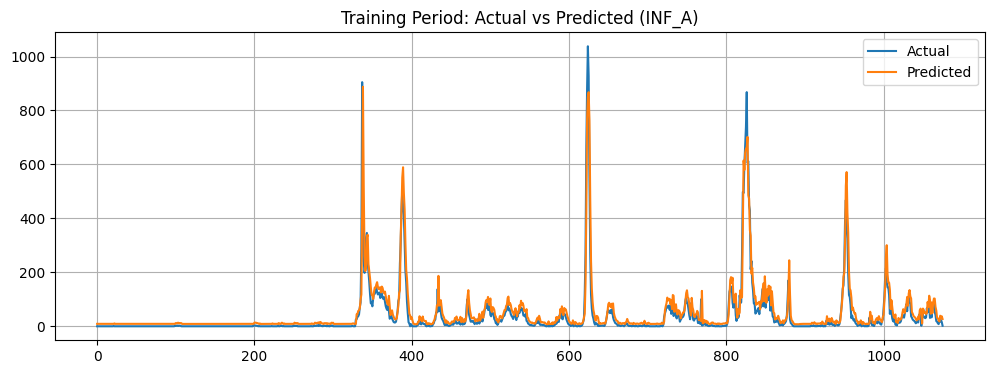

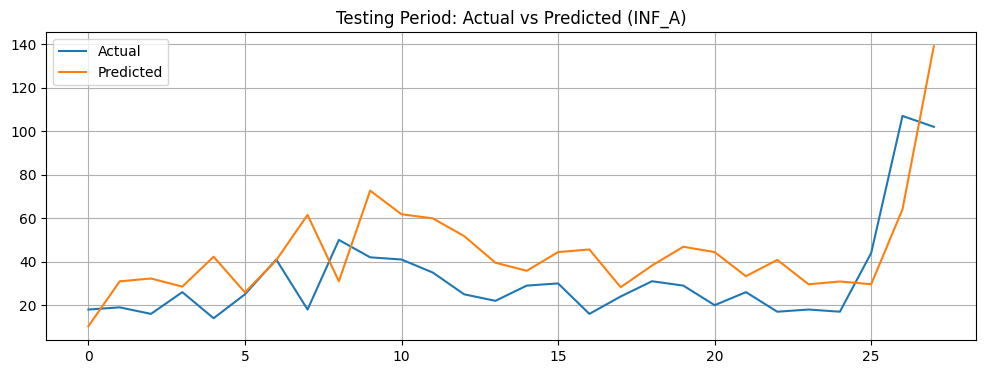


Processing INF_B...
1/1 [==============================] - 0s 15ms/step
INF_B - RMSE: 4.76, MAE: 3.60, MAPE: 65.73%


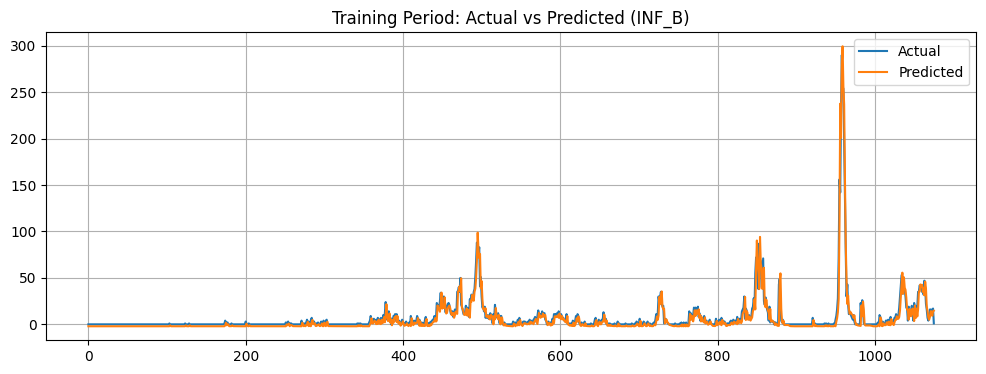

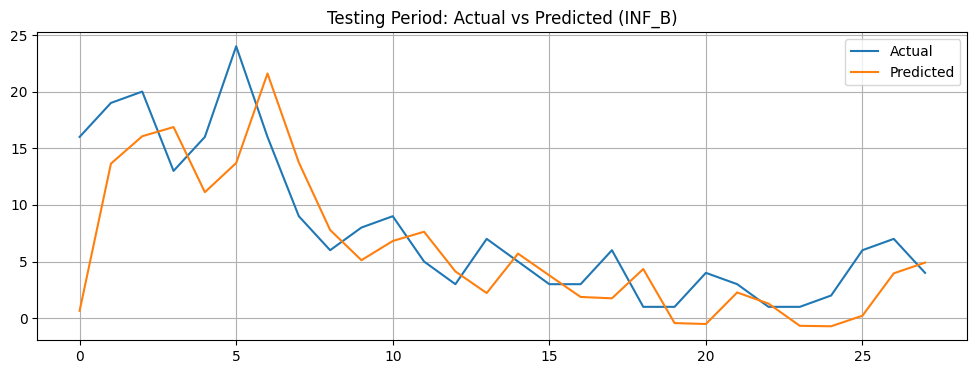

In [68]:
for col in ['INF_A', 'INF_B']:
    print(f"\nProcessing {col}...")

    # Prepare data
    data = df[[col]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_len=12):
        xs, ys = [], []
        for i in range(len(data) - seq_len):
            xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len])
        return np.array(xs), np.array(ys)

    SEQ_LEN = 12
    X, y = create_sequences(data_scaled, SEQ_LEN)

    # Train-test split
    split_date = '2024'
    split_idx = df.index < split_date
    X_train = X[split_idx[SEQ_LEN:]]
    y_train = y[split_idx[SEQ_LEN:]]
    X_test = X[~split_idx[SEQ_LEN:]]
    y_test = y[~split_idx[SEQ_LEN:]]

    # Build Transformer model
    class TimeSeriesTransformer(tf.keras.Model):
        def __init__(self, seq_len, d_model=32, num_heads=2):
            super().__init__()
            self.embedding = tf.keras.layers.Dense(d_model)
            self.pos_encoding = self.add_weight(
                "pos_encoding",
                shape=(1, seq_len, d_model),
                initializer="random_normal",
                trainable=True
            )
            self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
            self.norm1 = tf.keras.layers.LayerNormalization()
            self.norm2 = tf.keras.layers.LayerNormalization()
            self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(d_model * 2, activation='relu'),
                tf.keras.layers.Dense(d_model)
            ])
            self.output_layer = tf.keras.layers.Dense(1)

        def call(self, x):
            x = self.embedding(x)
            x += self.pos_encoding
            attn_output = self.attention(x, x)
            x = self.norm1(x + attn_output)
            ffn_output = self.ffn(x)
            x = self.norm2(x + ffn_output)
            return self.output_layer(x[:, -1, :])

    model = TimeSeriesTransformer(seq_len=SEQ_LEN)
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Evaluate on train
    train_preds = model.predict(X_train)
    train_preds_inv = scaler.inverse_transform(train_preds)
    y_train_inv = scaler.inverse_transform(y_train)

    # Evaluate on test
    test_preds = model.predict(X_test)
    test_preds_inv = scaler.inverse_transform(test_preds)
    y_test_inv = scaler.inverse_transform(y_test)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))
    mae = mean_absolute_error(y_test_inv, test_preds_inv)
    mape = np.mean(np.abs((y_test_inv - test_preds_inv) / y_test_inv)) * 100

    print(f"{col} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    # Plot training
    plt.figure(figsize=(12, 4))
    plt.plot(y_train_inv, label='Actual')
    plt.plot(train_preds_inv, label='Predicted')
    plt.title(f'Training Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot testing
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(test_preds_inv, label='Predicted')
    plt.title(f'Testing Period: Actual vs Predicted ({col})')
    plt.legend()
    plt.grid(True)
    plt.show()

#### We have got some improved metrics with respect to INF_B through this experiment